## Algoritmo de Grover

In [ ]:
# Vamos a crear una lista sobre la cual queremos buscar un elemento

lista = [1,3,5,2,4,9,5,8,0,7,6]

In [ ]:
# clasicamente podemos definir una caja negra a la cual le podemos preguntar si existe el numero 7
def oracle(input):
    winner = 7
    if  input is winner:
        response = True
    else:
        response = False
    return response

¿Cuántas veces debemos consultar nuestro oraculo antes de encontrar la solución?

In [ ]:
for index, trial_number in enumerate(lista):
    if oracle(trial_number) is True:    # si el oraculo nos dice que el numero es el 7
        print(f"El numero 7 se encuentra en la posicion {index} de la lista")
        print(f"El numero de llamadas al oraculo fue {index+1}")
        break

En promedio necesitamos llamar nuestro oraculo $N/2$ y en el peor caso necesitamos llamar el oraculos $N$ veces. En computación clásica este problema escala como $Q(N)$. Ahora bien, lo increible de la computación cuántica es que este mismo problema escala como $O(\sqrt{N})$. Esto es lo que se conoce como la mejora cuadratica. 

***El oráculo*** en el caso cuántico es una fcunión que me dice nos da una señal si el input es el ganador, por lo que podemos codificar nuestras entradas como el conjunto base de una computadora cuántica, recuerden que dos qubits nos permiten resentar cuatro estados de entrada.

$$
\{ |00\rangle, |01\rangle, |10\rangle, |11\rangle \}
$$

Supongamos que nuestro gandor es el estado $|11\rangle$ al pasar este estado por el ***oráculo*** obtenemos $-|11\rangle$. La forma en la que podemos hacer estos cambios es haciendo uso de matrices unitarias $U_{unitaria}$ que podemos codificar en un circuito cuántico. En este caso queremos un circuito que cambie el signo del estado $|11\rangle$.

$$
U_{unitaria} |x\rangle = - |x\rangle
$$


In [1]:
import math

# Imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler



In [2]:
# Para ejecutar en hardware, seleccione el backend con la menor cantidad de trabajos en la cola
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(f"Usando el backend: {backend.name}")

Usando el backend: ibm_brisbane


# Algoritmo de Grover: Mapeo de Entradas Clásicas a un Problema Cuántico

### Paso 1: Mapear Entradas Clásicas a un Problema Cuántico

El algoritmo de Grover requiere un oráculo que especifique uno o más **estados marcados de la base computacional**, donde "marcado" significa un estado con una fase de -1.

1. **Puerta Z-Controlada**:
   - Una puerta Z-controlada, o su generalización con múltiples controles sobre $ N $ cúbits, marca el estado $ 2^N - 1 $ (una cadena de bits de '1' repetida $ N $ veces).

2. **Marcar Estados de Base con '0'**:
   - Para marcar estados de base con uno o más '0' en su representación binaria, se aplican **puertas X** a los cúbits correspondientes **antes y después** de la puerta Z-controlada. Esto equivale a tener un control abierto en ese cúbit.

3. **Implementación**:
   - El siguiente código demuestra cómo definir un oráculo que marca uno o más estados de base definidos a través de su representación binaria.
   - La puerta **MCMT** (Multi-Control Multi-Target) se utiliza para implementar la puerta Z-controlada con múltiples controles.

### Componentes Clave:
- **Oráculo**: Marca los estados de la base computacional requeridos invirtiendo su fase a -1.
- **Puertas X**: Se usan para manejar los cúbits que necesitan ser marcados con '0' en su representación.
- **Puerta MCMT**: Implementa la puerta Z-controlada con múltiples controles necesaria para marcar estados.

Este enfoque permite flexibilidad para marcar estados según su representación binaria.


In [3]:
# Vamos a definir nueestro oraculo cuantico
def grover_oracle(selected_states):
    """
    Vamos a asumir que todos los estados tienen el mismo numero de bits

    Parameters:
        selected_states (str o list): Estados que queremos que el oraculo marque como correctos

    Returns:
        QuantumCircuit: Circuito que implementa el oraculo de Grover
    """
    if not isinstance(selected_states, list):
        selected_states = [selected_states]
    
    # Calcular el numero de quibits necesarios
    num_qubits = len(selected_states[0])

    # Definir los registros cuanticos
    qbits = QuantumRegister(num_qubits, name='q')
    qc = QuantumCircuit(qbits, name='Grover Oracle')

    # Marcar cada estado objetivo en la lista de entrada
    for target in selected_states:
        # invertir la cadena de bits para que coincida con el orden de bits de Qskit
        reversed_target = target[::-1]
        # Encontrar los indices de todos los elementos '0' en la cadena
        zeros_idx = [i for i in range(num_qubits) if reversed_target.startswith('0', i)]
        # Agregar un puerta Z multi-controlada con compuertas X antes y despues donde la cadena 
        # tiene un '0'
        qc.x(zeros_idx)
        qc.compose(MCMT(ZGate(),num_qubits-1,1), inplace=True)
        qc.x(zeros_idx)
    return qc



# Instancia Específica del Algoritmo de Grover

### Definición de una Instancia Específica

Ahora que contamos con la función de oráculo, podemos definir una instancia específica de la búsqueda de Grover. 

### Ejemplo:
En este ejemplo, marcaremos dos estados computacionales entre los ocho disponibles en un espacio computacional de tres cúbits:

1. **Espacio Computacional**:
   - Tres qubits generan $ 2^3 = 8 $ estados computacionales posibles.

2. **Estados Marcados**:
   - Seleccionamos dos estados computacionales específicos que serán marcados por el oráculo.

Este enfoque nos permite personalizar el algoritmo de Grover para resolver problemas concretos dentro de un espacio computacional limitado.


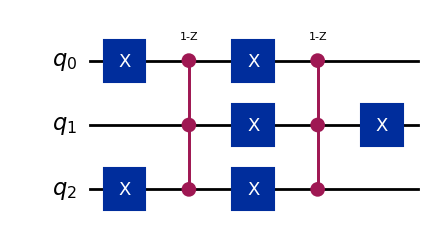

In [16]:
marked_states = ["010", "101"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")


# GroverOperator

### Introducción al GroverOperator

El **GroverOperator** integrado en Qiskit toma un circuito de oráculo como entrada y devuelve un circuito compuesto por:

1. **El circuito del oráculo**: Marca los estados deseados.
2. **Un circuito de amplificación**: Incrementa la amplitud de los estados marcados por el oráculo.

### Descomposición del Operador

Para entender cómo funciona internamente, podemos descomponer el circuito del **GroverOperator** y observar las puertas que lo componen. Esto nos permite analizar cómo:

- El oráculo marca los estados deseados.
- El operador de amplificación refuerza las probabilidades de los estados marcados.

### Uso:

El **GroverOperator** facilita la implementación del algoritmo de Grover, encapsulando la lógica necesaria para marcar y amplificar los estados en un único operador que puede integrarse fácilmente en aplicaciones de búsqueda cuántica.


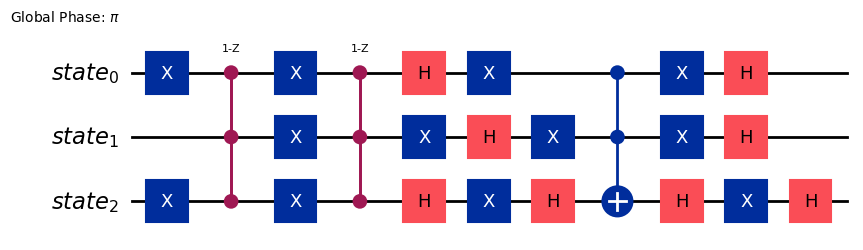

In [17]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")


Las aplicaciones repetidas del circuito **GroverOperator** amplifican las amplitudes de los estados marcados, haciendo que estos sean los **bit-strings más probables** en la distribución de salida del circuito.

1. **Efecto de las Aplicaciones**:
   - Cada iteración del operador Grover amplifica la probabilidad de los estados marcados mientras reduce la probabilidad de los no marcados.

2. **Número Óptimo de Aplicaciones**:
   - Existe un número óptimo de aplicaciones del operador Grover, que depende de la relación entre:
     - **Estados Marcados** ($ M $): Los estados que se desean encontrar.
     - **Estados Totales** ($ N $): El número total de estados computacionales posibles.
   - Este número óptimo se calcula aproximadamente como:
     $$
     t \approx \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{M}} \right\rfloor
     $$
   - Aplicar el operador más allá de este punto puede reducir la probabilidad de los estados marcados debido a oscilaciones en las amplitudes.

3. **Distribución de Salida**:
   - Tras aplicar el operador el número óptimo de veces, los estados marcados se vuelven dominantes en la distribución de salida, maximizando la probabilidad de medirlos.

### Importancia:
Este equilibrio entre amplificación y oscilación es una característica clave del algoritmo de Grover, permitiendo su eficiencia cuadrática en la búsqueda dentro de un espacio de estados computacionales.


In [18]:
print(f"Numero de qubits: {grover_op.num_qubits}")
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)
optimal_num_iterations

Numero de qubits: 3


1

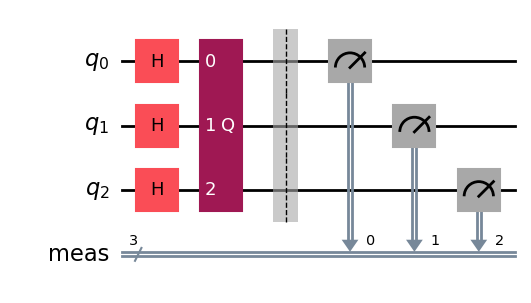

In [19]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

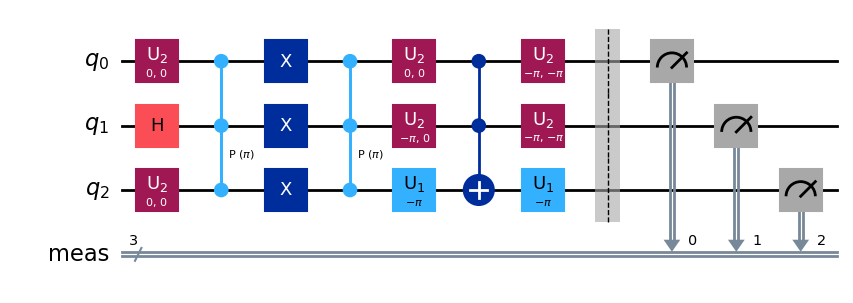

In [20]:

# Creamos el simulador cuántico
qasm_simulator = Aer.get_backend('qasm_simulator')

# Transpilamos el circuito para el backend
transpiled_qc = transpile(qc, qasm_simulator)
transpiled_qc.draw(output='mpl')    

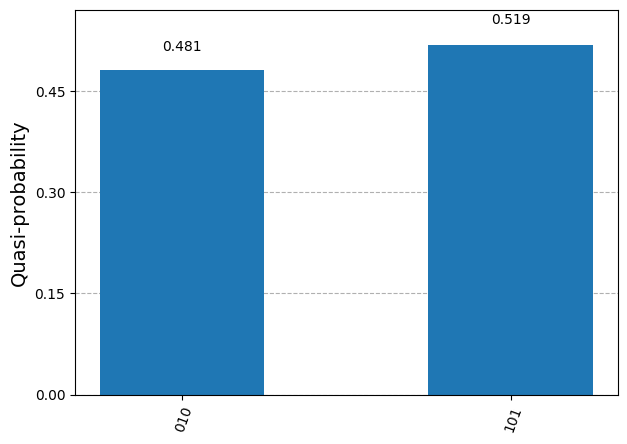

In [21]:

job = qasm_simulator.run(transpiled_qc, shots=1024)
result = job.result()

# Mostramos el histograma con los resultados
counts = result.get_counts()
plot_distribution(counts)

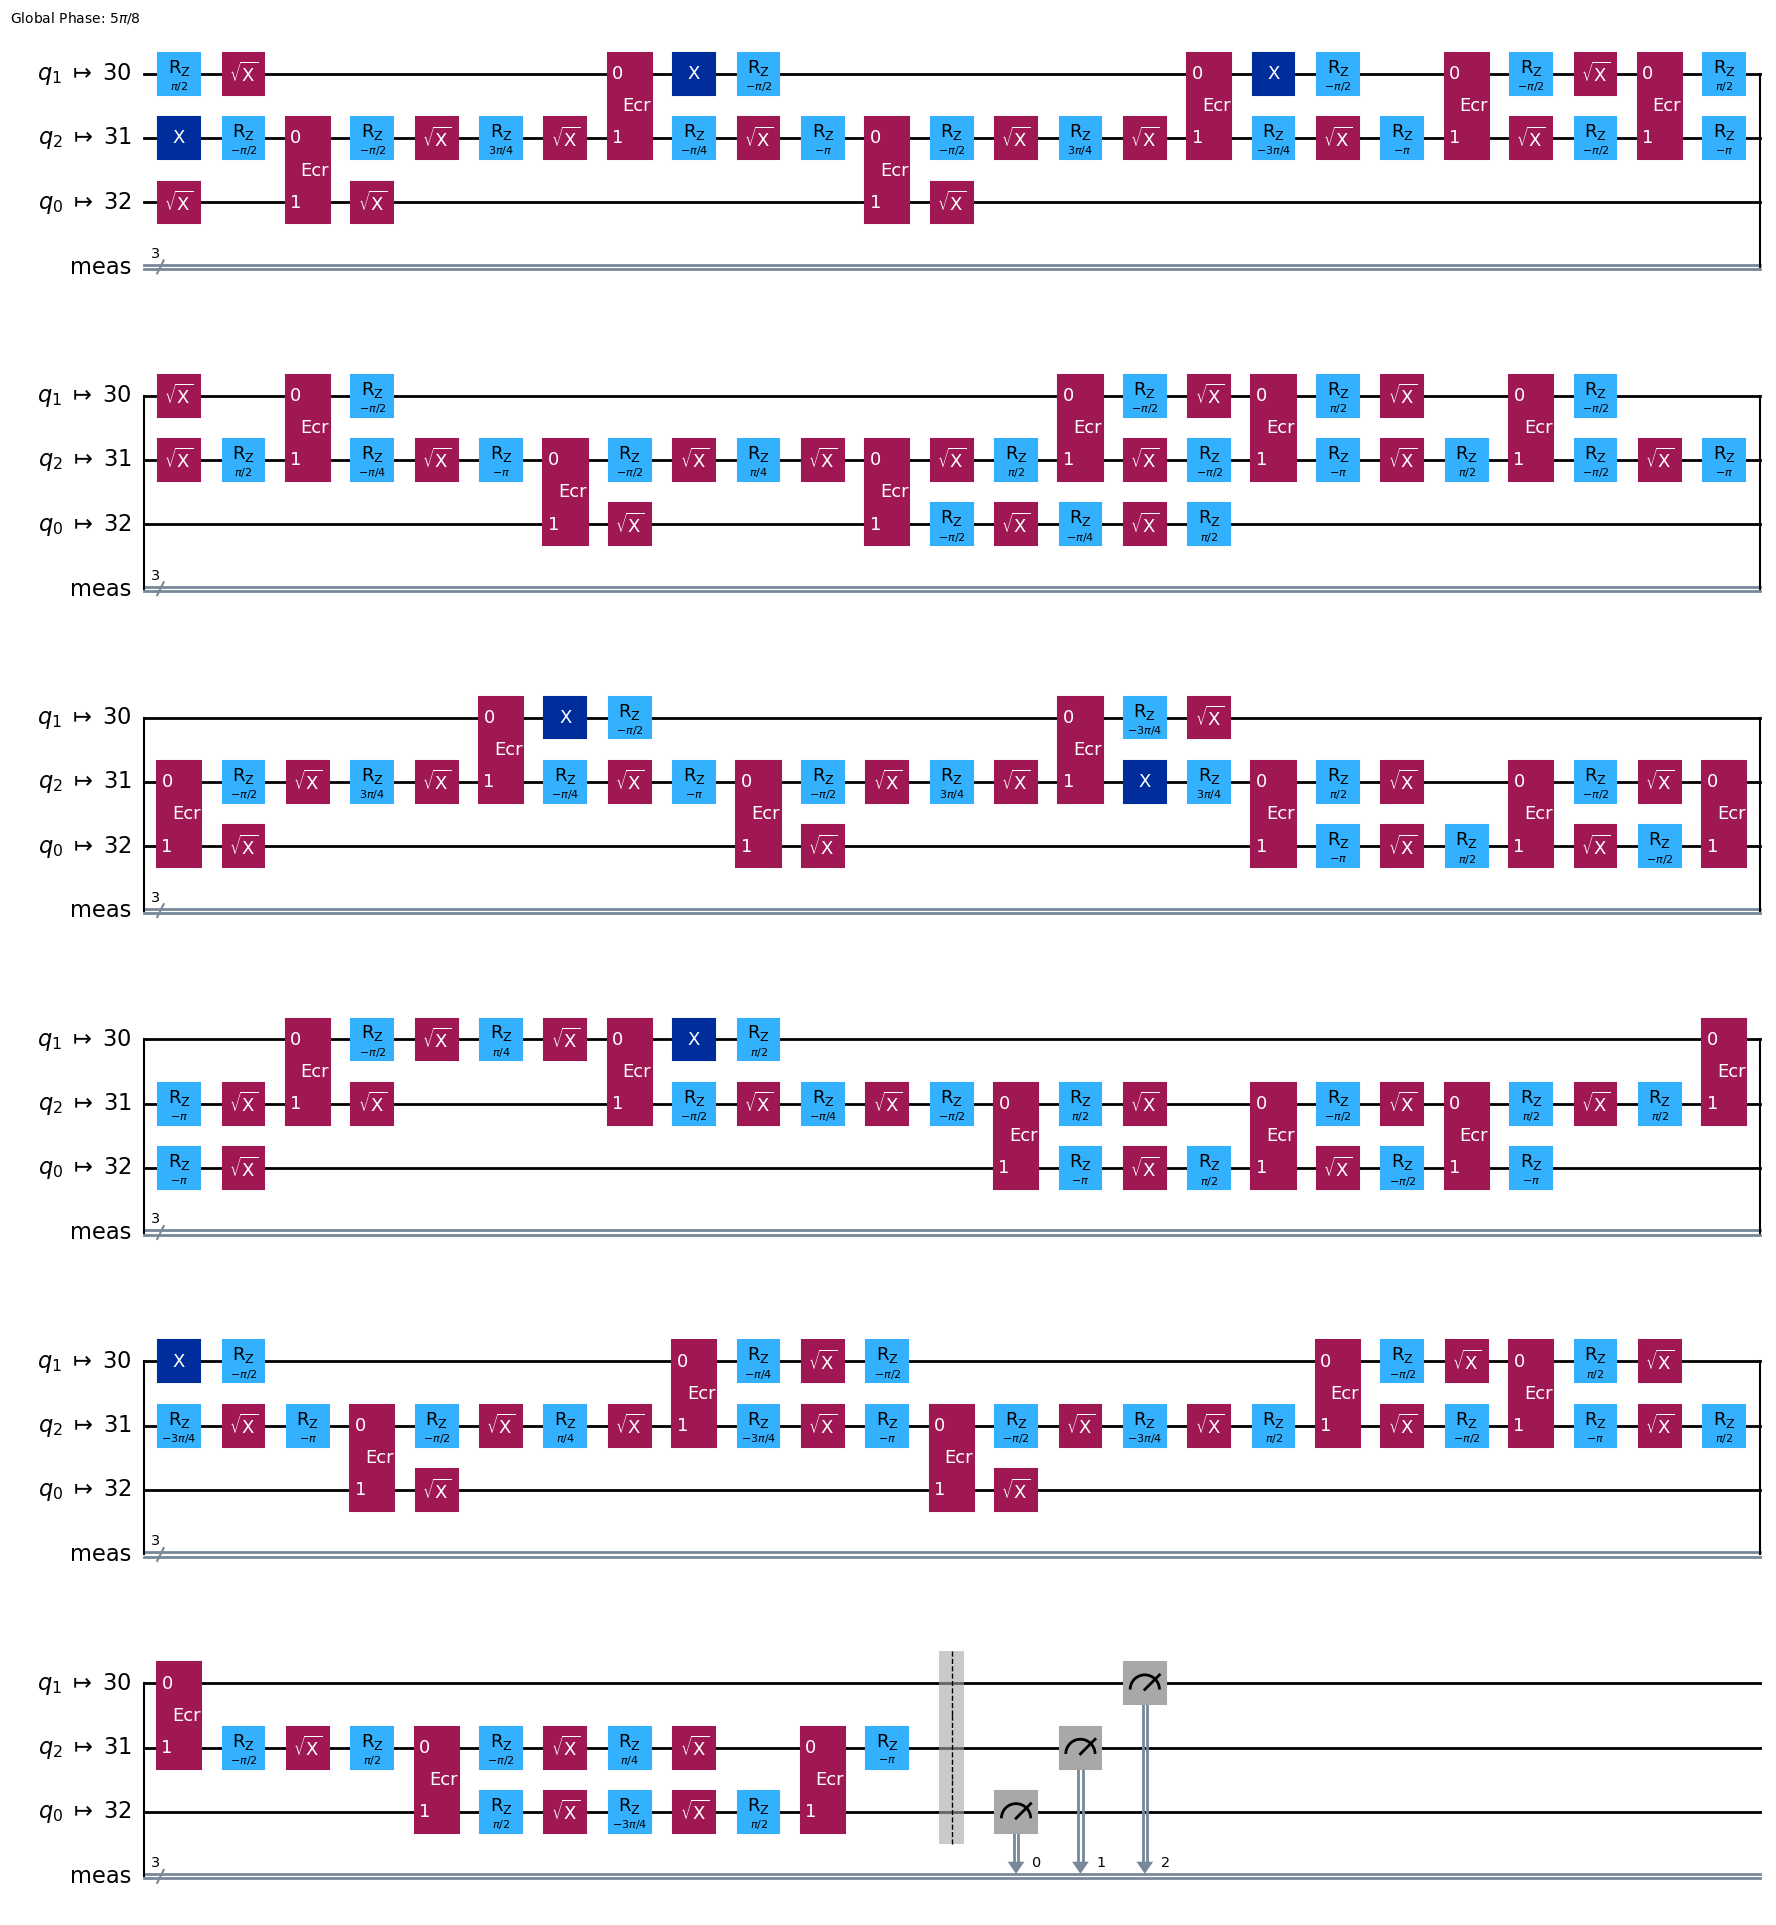

In [22]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=1)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [ ]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
job = sampler.run([circuit_isa])
# Recuperar los resultados
id = job.job_id()
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cxds5gy6t010008ccrtg
<class 'str'>


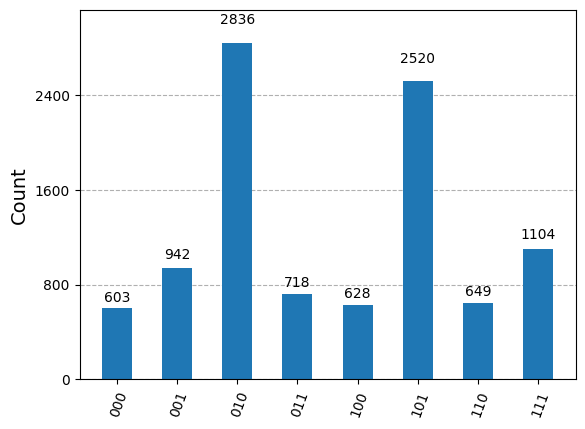

In [24]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='bd0b91e744904acd322a103a75e6803c5f96e228ae5958b369339a1e86cf2cf3bfd75065de732a7dc9290665dd3aac53d1ed79f5f3c958b0cd8ecd43006750be'
)
job = service.job(id)
job_result = job.result()


pub_result = job_result[0].data.meas.get_counts()
plot_histogram(pub_result)